In [102]:
import pandas as pd
import numpy as np
import datetime as dt


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
import pyod

In [76]:
def load_dataset(plant):
    print(f'loading plant {plant} data')
    train = pd.read_csv(f'../data/train_{plant}.csv', parse_dates=["时间"]).drop_duplicates().reset_index(drop=True)
    test = pd.read_csv(f'../data/test_{plant}.csv', parse_dates=["时间"])
    train.columns = ['time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm', 'mirr', 'power']
    test.columns = ['id', 'time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm']
    data = pd.concat([train, test])
    return data

In [77]:
d = [load_dataset(i+1) for i in range(4)]

loading plant 1 data
loading plant 2 data
loading plant 3 data
loading plant 4 data


In [117]:
def data_preprocessing(data):
    data.reset_index(drop=True, inplace=True)
    print(f'start clear data')
    train = data.id.isnull()
    data['time'] = data['time'] + dt.timedelta(seconds=0.5)
    # power outlier
    tmp = data[data.power > 0].copy()
    mirr_Q3 = np.percentile(tmp.mirr, 75)
    mirr_Q1 = np.percentile(tmp.mirr, 25)
    power_q10 = np.percentile(tmp.power, 25)
    power_q90 = np.percentile(tmp.power, 75)
    low = (data.mirr>=mirr_Q3) & (data.power<=power_q10)
    high = (data.mirr<=mirr_Q1) & (data.power>=power_q90)
    outlier = low | high
    print(f'detect power outlier: {outlier.sum()}')
    if outlier.sum() > 0:
        print(f'processing power outlier')
#         power_table=data[train].groupby(data.time.dt.hour)['power'].agg({
#             "high": lambda x: np.percentile(x, 95), 
#             "low": lambda x: np.percentile(x, 5)}).to_dict()
#         for hour in range(1, 24):
#             data.loc[high & (data.time.dt.hour == hour), 'power'] = power_table['high'][hour]
#             data.loc[low & (data.time.dt.hour == hour), 'power'] = power_table['low'][hour]
        knn = KNeighborsRegressor(n_neighbors=40)
        knn.fit(data.loc[train & ~outlier, ['irr', 'mirr', 'temp', 'hm']], data.loc[train & ~outlier, 'power'])
        data.loc[outlier, 'power'] = knn.predict(data.loc[outlier, ['irr', 'mirr', 'temp', 'hm']])

#     irr_q10 = np.percentile(tmp.irr, 1)
#     irr_q90 = np.percentile(tmp.irr, 99)
#     low = ((data.mirr>=mirr_Q3) & (data.power<=irr_q10))
#     high = ((data.mirr<=mirr_Q1) & (data.power>=irr_q90))
#     outlier = low | high
#     print(f'detect irr outlier: {outlier.sum()}')
#     if outlier.sum() > 0:
#         print(f'processing irr outlier')
#         irr_table=data[train].groupby(data.time.dt.hour)['irr'].agg({
#             "high": lambda x: np.percentile(x, 75), 
#             "low": lambda x: np.percentile(x, 25)}).to_dict()
#         for hour in range(1, 24):
#             data.loc[high & (data.time.dt.hour == hour), 'irr'] = irr_table['high'][hour]
#             data.loc[low & (data.time.dt.hour == hour), 'irr'] = irr_table['low'][hour]
    return data

loading plant 1 data
start clear data
detect power outlier: 12
processing power outlier


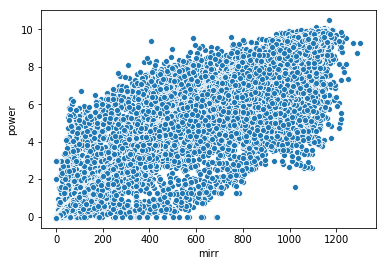

In [120]:
d3 = data_preprocessing(load_dataset(1))
sns.scatterplot('mirr', 'power', data=d3)

loading plant 1 data


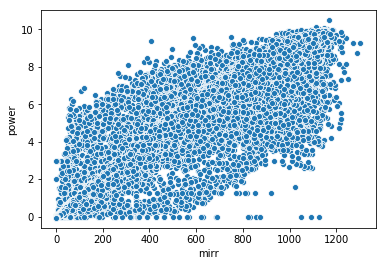

In [121]:
d3 = load_dataset(1)
sns.scatterplot('mirr', 'power', data=d3)

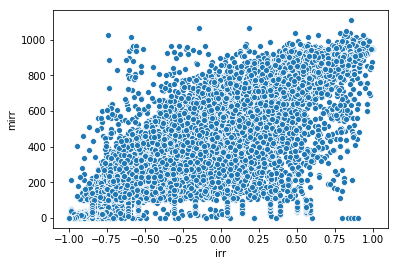

In [84]:
sns.scatterplot('irr', 'mirr', data=d3)

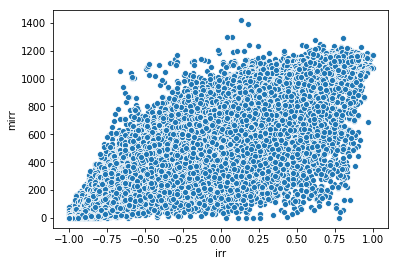

In [90]:
sns.scatterplot('irr', 'mirr', data=d[3])